In [1]:
from home_finder.text_analysis import TfIdfMaker
from home_finder.image_analysis import AI_SimRanker
from home_finder.similar_properties import SimilarProperties

In [2]:
ranking_weights = {'tf_idf_cosine': 1.5, 'neighbours': 1.0, 'object_detection': 1.2, 'ai_similarity': 2.5}
r_types = ['tf_idf_cosine', 'neighbours', 'object_detection', 'ai_similarity']

# img_input = SimilarProperties().ready('sample_property_images.csv')
# SimilarProperties.ensemble(input=img_input, ranking_types=r_types)

In [3]:
all_data = SimilarProperties().ready('sample_property_images.csv')
train = all_data[:int(len(all_data)*0.8)]
test = all_data[int(len(all_data)*0.8):]

print(len(train))
print(len(test))

Preparing image data...
472 image data items ready for analysis.
377
95


In [4]:
SimilarProperties.ensemble(input=train, ranking_types=r_types, weights=ranking_weights)
SimilarProperties.image_retriever.tf_maker.transformed_data

Extracting object features...


array([[   -0.11113,    -0.11551,    -0.22078, ...,    -0.26436,     -0.6067,    -0.11529],
       [   -0.11113,    -0.11551,    -0.22078, ...,      3.6713,     -0.6067,    -0.11529],
       [   -0.11113,    -0.11551,    -0.22078, ...,    -0.26436,      1.1004,    -0.11529],
       ...,
       [   -0.11113,    -0.11551,    -0.22078, ...,    -0.26436,      2.8857,    -0.11529],
       [   -0.11113,    -0.11551,    -0.22078, ...,    -0.26436,       1.797,    -0.11529],
       [   -0.11113,    -0.11551,    -0.22078, ...,    -0.26436,     -0.6067,    -0.11529]], shape=(377, 396))

In [5]:
allowed = SimilarProperties.image_retriever.object_maker.allowed_objects
print(len(allowed))
allowed[:20]

396


array(['accent', 'accents', 'access', 'add', 'adding', 'adds', 'adjacent', 'adjoining', 'adorned', 'aerial', 'allowing', 'allows', 'alongside', 'amenities', 'ample', 'apartment', 'appears', 'appliances', 'architectural', 'architecture'], dtype=object)

In [6]:
test_words = {i: {'features': SimilarProperties.image_retriever.tf_maker.transform(imgd.description), 'words': [w for w in SimilarProperties.image_retriever.tf_maker.word_features if w in imgd.description]} for i, imgd in enumerate(test)}
test_words

{0: {'features': array([[   -0.11113,    -0.11551,    -0.22078,    -0.12678,    -0.12664,    -0.11541,    -0.26483,    -0.17846,    -0.13656,    -0.18056,    -0.16306,    -0.16313,    -0.11546,    -0.13701,    -0.20829,    -0.11103,    -0.44127,    -0.29087,    -0.19464,    -0.13669,    -0.68566,    -0.17211,    -0.14403,
             -0.11579,    -0.15536,    -0.17254,    -0.13734,     -0.1991,    -0.25867,      9.3249,    -0.12139,    -0.11226,    -0.11469,    -0.12644,    -0.31054,    -0.20785,    -0.12634,    -0.32245,    -0.25292,    -0.20965,    -0.15539,    -0.15349,    -0.13721,     -0.1618,     -0.1867,    -0.18703,
             -0.12651,    -0.11551,    -0.12684,    -0.11495,      2.0536,    -0.12666,      1.5934,    -0.25359,    -0.41809,    -0.19504,    -0.31747,    -0.27253,    -0.12605,    -0.24658,    -0.38595,    -0.19498,      5.5103,    -0.41256,    -0.22126,    -0.25336,    -0.34195,    -0.12692,    -0.13606,
             -0.13687,    -0.21592,    -0.13712,    -0.163

In [11]:
from ultralytics.solutions import VisualAISearch
ai_image_model:VisualAISearch = [r for r in SimilarProperties.image_retriever.ranking_types if r._name() == 'ai_similarity'][0].ai_model
ai_image_model

In [ ]:
import random
import math
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from ultralytics.solutions import VisualAISearch
from tqdm import tqdm

ai_image_model:VisualAISearch = [r for r in SimilarProperties.image_retriever.ranking_types if r._name() == 'ai_similarity'][0].ai_model
together_dfs = []
retrieval_similarities = []

for i, tim in tqdm(enumerate(list(test_words.values())[:20])):
    n_kw = len(tim['words'])

    random_kws = []
    for _ in range(math.ceil(n_kw*0.1)):
        keyw = (random.choice(tim['words']))
        if keyw not in random_kws:
            random_kws.append(keyw)
    
    query = ' '.join(random_kws)
    print('query created!')
    
    most_relevant = SimilarProperties().query(query, show=False)
    print('retrieved most relevant')
    candidate_imgs = [imd.path_name for imd in most_relevant]

    test_img_features = ai_image_model.extract_image_feature(test[i].path_name)
    
    retrieved_img_features = np.vstack([ai_image_model.extract_image_feature(ret.path_name) for ret in most_relevant])

    for rif in retrieved_img_features:
        rif = rif.reshape(1,-1)

        sims = cosine_similarity(rif, test_img_features)
        retrieval_similarities.append(sims.tolist()[0][0])
    retrieval_similarities.append(1.0)
    

    testing_together = pd.DataFrame(np.vstack([retrieved_img_features, test_img_features]))
    names = ['retrieved' for _ in range(5)]
    names.append('query') 
    testing_together['type'] = names
    print('dataframe made')
    together_dfs.append(testing_together)


results_df = pd.concat(together_dfs, ignore_index=True)

pca = PCA(n_components=2)
pca_results = pd.DataFrame(pca.fit_transform(results_df.iloc[:,:-1]), columns=['f_0', 'f_1'])
pca_results['type'] = results_df['type']
pca_results['similarity'] = retrieval_similarities
pca_results

0it [00:00, ?it/s]

query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


1it [00:07,  7.29s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


2it [00:14,  6.98s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


3it [00:19,  6.48s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


4it [00:28,  7.21s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


5it [00:34,  6.96s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


6it [00:43,  7.40s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


7it [00:50,  7.31s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


8it [00:55,  6.69s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


9it [01:02,  6.90s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


10it [01:07,  6.28s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


11it [01:14,  6.33s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


12it [01:20,  6.32s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


13it [01:25,  5.89s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


14it [01:30,  5.61s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


15it [01:37,  5.91s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


16it [01:42,  5.82s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


17it [01:49,  6.02s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


18it [01:54,  5.82s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


19it [02:01,  6.32s/it]

dataframe made
query created!
Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...
retrieved most relevant


20it [02:09,  6.46s/it]

dataframe made


ValueError: Length of values (100) does not match length of index (120)

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

In [ ]:
avg_sim = float(np.mean(pca_results['similarity']))
mean_sq_err = np.mean([1 - abs(s) for s in list(pca_results)])

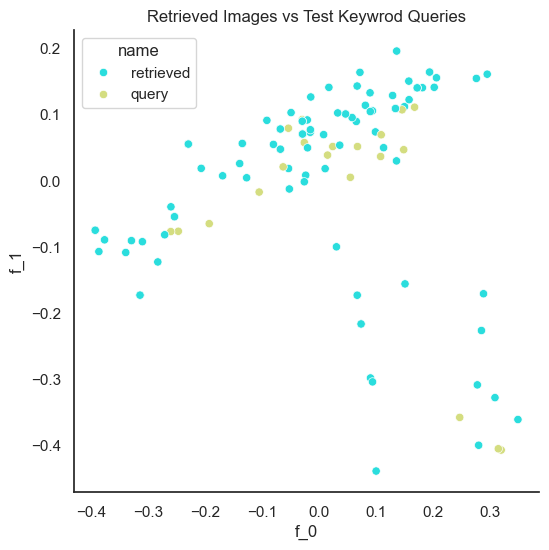

In [ ]:
plt.figure(figsize=(6,6));
sns.scatterplot(pca_results, x='f_0', y='f_1', hue='name', palette='rainbow');
sns.despine();
plt.title('Retrieved Images vs Test Keyword Queries');

In [7]:
# now to test:
import random
import math

test_1 = test_words[0]
n_kw = len(test_1['words'])
# print(n_kw)

random_kws = []
for _ in range(math.ceil(n_kw*0.1)):
    keyw = (random.choice(test_1['words']))
    if keyw not in random_kws:
        random_kws.append(keyw)

random_kws

['cars', 'car', 'tree']

Ranking images with tf_idf_cosine...
Ranking images with neighbours...


Ranking images with object_detection...
Ranking images with ai_similarity...
Searcher validation failed, rebuilding...


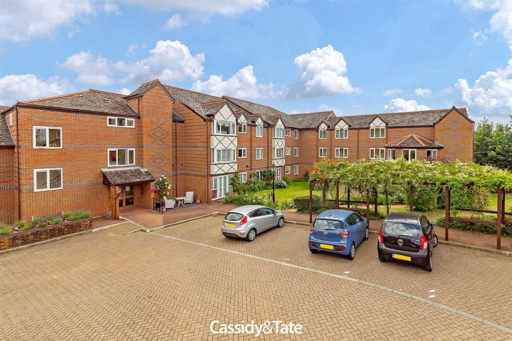

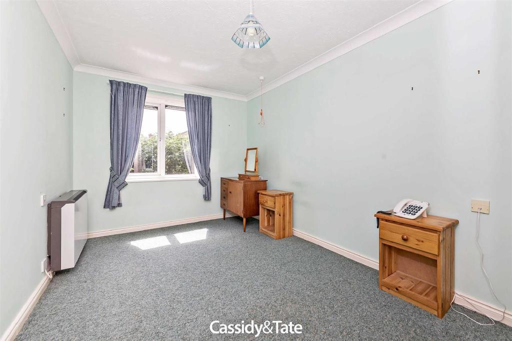

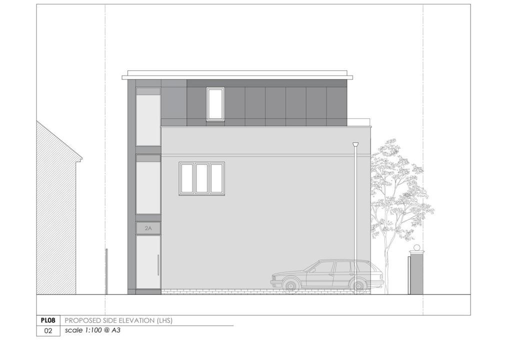

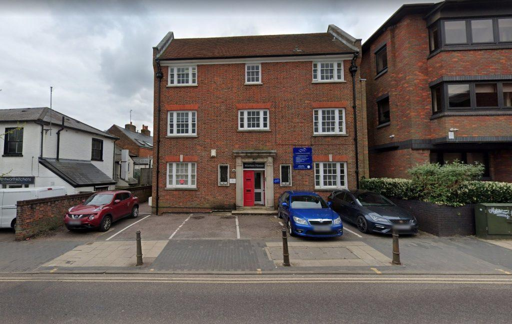

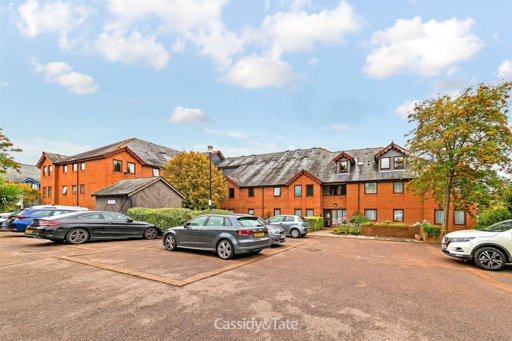

[ImageData(url='https://media.rightmove.co.uk/175k/174341/117898208/174341_31174185_IMG_22_0000.jpeg', description='This image shows a multi-unit residential building with brick construction and white-framed windows. It features three storeys with an exterior of clean lines and a combination of sloped and gable roofs. The parking lot in the foreground provides off-street parking. Surrounding greenery adds a natural touch to the setting.', path_name='tmp/images/174341_31174185_IMG_22_0000.jpeg', objects={'car': 0.7796395421028137, 'potted plant': 0.4118536114692688}, scores={'tf_idf_cosine': 0.0471211386308633, 'neighbours': 0.8098012071266731, 'object_detection': np.float64(0.7796395421028137), 'ai_similarity': 0.9257294429708223, 'final_score': 1.0}),
 ImageData(url='https://media.rightmove.co.uk/175k/174341/117898208/174341_31174185_IMG_09_0000.jpeg', description='The room features a light-colored carpet and light pastel walls. It includes a window with draped curtains, two wooden pi

In [8]:
most_relevant = SimilarProperties.query(query=' '.join(random_kws))
most_relevant

In [33]:
from ultralytics.solutions import VisualAISearch
candidate_imgs = [imd.path_name for imd in most_relevant]
ai_image_model:VisualAISearch = [r for r in SimilarProperties.image_retriever.ranking_types if r._name() == 'ai_similarity'][0].ai_model
ai_image_model

In [47]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

test_img_features = ai_image_model.extract_image_feature(test[0].path_name)
print(test_img_features.shape)
# test_img_features

retrieval_similarities = []
retrieved_img_features = np.vstack([ai_image_model.extract_image_feature(ret.path_name) for ret in most_relevant])
print(retrieved_img_features.shape)

for rif in retrieved_img_features:
    rif = rif.reshape(1,-1)
    print(rif.shape)

    sims = cosine_similarity(rif, test_img_features)
    retrieval_similarities.append(sims.tolist()[0][0])


retrieval_similarities

(1, 512)
(5, 512)
(1, 512)
(1, 512)
(1, 512)
(1, 512)
(1, 512)


[0.796766996383667,
 0.6399405002593994,
 0.6539261937141418,
 0.8432434797286987,
 0.7399598956108093]

In [66]:
test_img_features

array([[  -0.032944,   -0.019474,    0.051775,    0.020915,    0.059671,   -0.011444,    0.050464,    0.015473,     0.07968,  -0.0082536,    0.010924,    0.044604,   0.0065472,   -0.061184,    0.012818,  -0.0079607,     0.01477,   -0.024741, -0.00082299,  -0.0019362,     0.10176,    0.017347,   0.0037294,
           0.030346,    0.040036,    0.046186,     0.02049,   -0.038169,   -0.022562,    0.019286,    0.016473,    0.020384,   -0.031913,   -0.010371,    0.032234,    0.029658, -0.00010785,   -0.025708,    0.016315,     0.15819,    0.011587,   -0.021877,   -0.032858,   -0.065262,   -0.041006,    -0.09827,
          0.0028599,   0.0071578,    0.002289,    0.047992,    0.029945,    0.058834,    0.039664,   -0.023959,    0.013096,    0.010028,  -0.0031252,  -0.0034862,    0.023644,    0.021885,    0.086372,   -0.011514,   -0.030456,   0.0019933,    -0.02059,   -0.014435,   0.0002964,    -0.07409,   -0.028469,
           0.033243,   0.0059919,  0.00034936,   -0.015561,   -0.017093,   0.00

In [67]:
# retrieved_img_features.shape
import pandas as pd

testing_together = pd.DataFrame(np.vstack([retrieved_img_features, test_img_features]))
names = ['retrieved' for _ in range(5)]
names.append('query') 
testing_together['type'] = names
testing_together

0         1         2         3         4         5         6  \
0 -0.053722 -0.025745  0.077344 -0.029307  0.047964  0.000547  0.031642   
1 -0.073171 -0.007105  0.052632 -0.000545  0.038694  0.003528  0.033466   
2 -0.000418  0.013518 -0.004103 -0.029804  0.027974 -0.028382  0.016807   
3  0.009322  0.003185  0.036895  0.007309  0.059801  0.007704  0.037712   
4 -0.021051 -0.022796  0.033575 -0.004366  0.029192 -0.002934  0.005546   
5 -0.032944 -0.019474  0.051775  0.020915  0.059671 -0.011444  0.050464   

          7         8         9  ...       503       504       505       506  \
0  0.016168  0.069520  0.021131  ...  0.024996 -0.040767  0.007597 -0.016037   
1 -0.008280  0.007355  0.006930  ...  0.019196 -0.016146 -0.017363 -0.020496   
2  0.033918  0.046087  0.021144  ...  0.030348  0.008652 -0.001377 -0.040200   
3  0.030823  0.075049  0.021207  ...  0.009800 -0.074634 -0.007186 -0.037592   
4  0.022154  0.045006 -0.012890  ...  0.027636 -0.028382 -0.002568  0.004793   
5  0.015473  0.079680 -0.008254  ...  0.034047 -0.034986 -0.014726 -0.038848   

        507       508       509       510       511       type  
0 -0.022209  0.048768 -0.023696  0.016680 -0.034907  retrieved  
1  0.031045 -0.018480 -0.020251 -0.009456  0.043764  retrieved  
2  0.039514  0.002595  0.032197 -0.018502 -0.056232  retrieved  
3 -0.019956  0.039128 -0.045275 -0.003678 -0.066449  retrieved  
4 -0.004727  0.057730 -0.010300  0.043292 -0.040254  retrieved  
5 -0.009697  0.017396  0.018627 -0.019698 -0.070019      query  

[6 rows x 513 columns]

In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_together = pd.DataFrame(pca.fit_transform(testing_together.iloc[:,:-1]), columns=['f_0', 'f_1'])
pca_together['type'] = testing_together['type']
pca_together

f_0       f_1       type
0 -0.153145  0.199886  retrieved
1  0.279306  0.394473  retrieved
2  0.493188 -0.337888  retrieved
3 -0.279605 -0.258674  retrieved
4 -0.133212  0.207366  retrieved
5 -0.206532 -0.205162      query

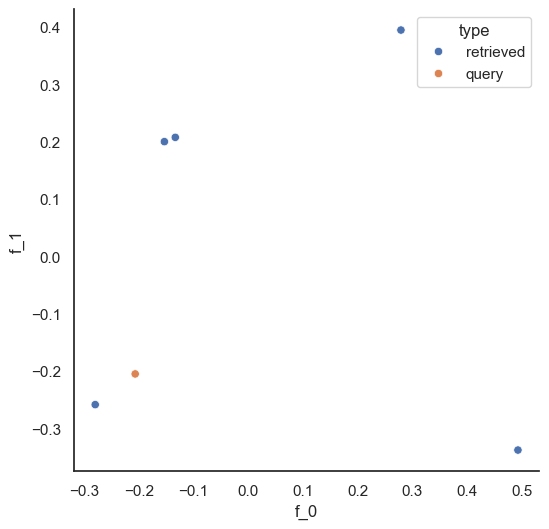

In [72]:
plt.figure(figsize=(6,6));
sns.scatterplot(pca_together, x='f_0', y='f_1', hue='type');
sns.despine();

Ranking images with tf_idf_cosine...
Ranking images with neighbours...
Ranking images with object_detection...
Ranking images with ai_similarity...
Error initializing searcher: No module named 'tqdm'
Clearing cache and retrying...
Failed to initialize searcher after cache clear: No module named 'tqdm'
Using fallback scoring (random)


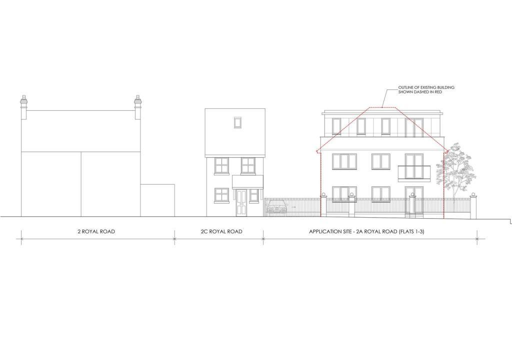

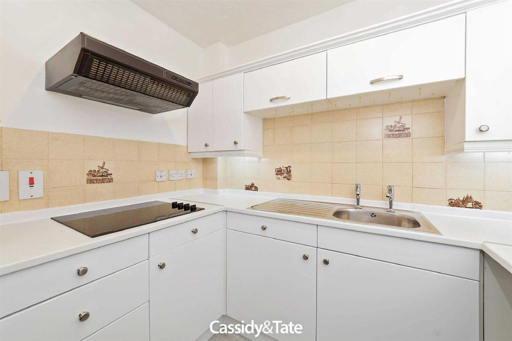

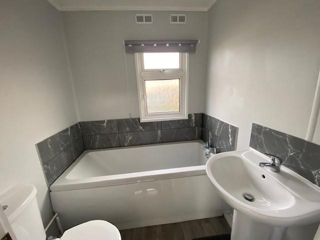

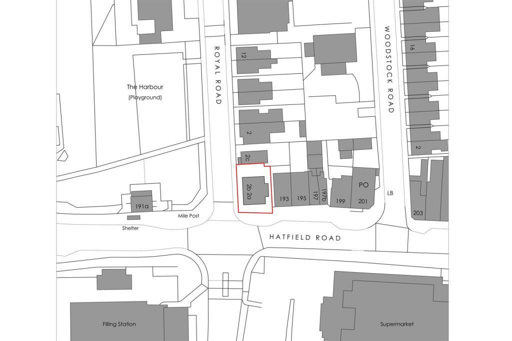

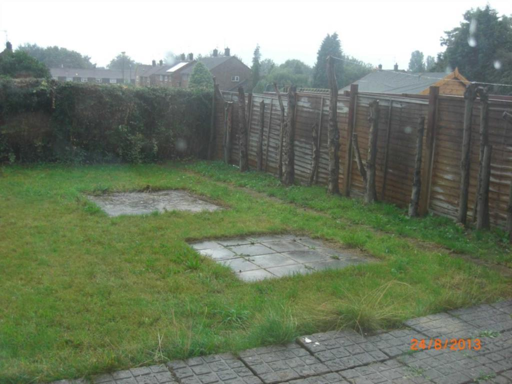

[ImageData(url='https://media.rightmove.co.uk/175k/174341/121777088/174341_31388259_IMG_01_0000.jpeg', description='This is an architectural elevation drawing showing a comparison between existing and proposed structures at 2A Royal Road. The left side of the drawing shows adjoining properties for context, while the right side provides a front view of the proposed building development highlighting the additions to the existing structure, depicted with a dashed red line. The design suggests a multi-level residential building with', path_name='tmp/images/174341_31388259_IMG_01_0000.jpeg', objects={}, scores={'tf_idf_cosine': 0.9548692596774182, 'neighbours': 0.5691666812614256, 'object_detection': 0.0, 'ai_similarity': 0.865177077858696, 'final_score': 0.597303254699385}),
 ImageData(url='https://media.rightmove.co.uk/175k/174341/117898208/174341_31174185_IMG_15_0000.jpeg', description='The image shows a kitchen with built-in white cabinets, a stainless steel sink, and ceramic hob. There

In [ ]:
# SimilarProperties.query('spacious kitchen, sunny living room')